### Stable Baselines are pre-trained agents that can be used for many gymnasium environments

In [1]:
# pip install stable-baselines3[extra]
import gymnasium as gym
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# display management
from IPython.display import clear_output
from IPython.utils import io

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
# Actually I did experiment with differnet these 3 (DQN, PPO, A2C) approaches 
# I found that PPO is much better and rest DNQ AND A2C almost the same but from these 2 of them also agent performance is better with DNQ.
# I am going to compare PPO which is performend really well with other 2 but here speically I will mention only DNQ beacause I already have example with this approach. After this, then I will go further experiments like by changing the paramters also little more insights.

In [4]:
# DQN updates Q-values and is slower with higher reward variance, while PPO converges faster and offers more stable performance, avoiding Q-learning instability.

# Performance & Improvements and Downside according to runing experiments both of it are as follows
# PPO tends to perform better overall in this specific environment (CartPole). It shows smoother convergence and more consistent rewards over time, likely due to its more stable and continuous learning process.
# DQN can struggle with large variance in performance, especially if the epsilon-decay and reward signal are not optimized correctly.
# Also with addition, I tried both DNQ AND A2C, both cannot reach the goal perfectly and went right or left side and game over Within in half steps sometime, But with PPO it perform very well and get 1000 Reward and performa according to expecations, very stable and with good results.
# PPO needs more computing power, requires tuning hyperparameters, and can take longer to find the best solution.

# Graph & Q-Table Comparison
# DQN graphs show a more erratic progression early on, with high variance, but ultimately the rewards stabilize after sufficient training.
# PPO graphs are smoother, indicating stable learning and gradual improvement in performance. PPO avoids the oscillations often seen with DQN.
# Q-Table: DQN maintains a Q-table (or approximation), which can be large and less efficient in environments with large state spaces, whereas PPO directly uses a policy network, which can scale better in complex environments.

# Overall Summary
# PPO is better in terms of performance stabile and got rewards maximums and DQN can still perform well but requires careful hyperparameter tuning and can be slower to converge with higher variance in performance for get better rewards.

In [5]:
# Since this is a pre-developed game, I got better results using PPO. Now, I’ll try experimenting by changing some parameters in PPO to see if performance improves further.

# policy_kwargs = dict(net_arch=[64, 64])
# The custom [64, 64] policy leads to faster (I found it much faster in training time) and smoother convergence on CartPole, with minor trade-offs in training time. It's a safe and effective upgrade over default architectures for this environment. At the end results also rewaded 1000 which we were expecting from this model.

# By increasing the numbers of steps it was 2000 and 5000
#Improvements:
# Better Stability Check: Longer test shows if the agent is consistently good.
# Failure Detection: More steps help spot rare failures.
# Accurate Rewards: Captures full reward trend over time.
# Downside of this experiment what i feel it
# Slower Run: Takes more time to execute.
# Adds little if agent already maxes out.


#model.learn(total_timesteps=500000, callback=RewardThresholdCallback(1000))
# By runing this experiment there is outcome.
# Episode rewards will stabilize near 1.0 and show a smoother curve staying near the top.
# The agent will learn to balance the pole effectively for long durations.
# Fewer spikes and more consistent results are expected after about 200,000 steps.

# Now reversing few chaning because i want to explain output like table and rewards etc



In [6]:
# create a custom callback in order to set a reward goal for the agent
# unfortunately there's no easier way to do this
class RewardThresholdCallback(BaseCallback):
    def __init__(self, reward_threshold, check_freq=1000, verbose=1):
        super().__init__(verbose)
        self.reward_threshold = reward_threshold
        self.check_freq = check_freq

    # override the on_step in the original model.learn
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            mean_reward = self.locals["infos"][-1].get("episode", {}).get("r")

            # see if we have matched our reward goal
            if mean_reward is not None and mean_reward >= self.reward_threshold:
                print(f"Stop training -> Target reward {self.reward_threshold} reached!")

                # stop training
                return False
            
        # otherwise continue training
        return True

In [7]:
# create model and train
# there's plenty of options to finetune the parameters
# this is just more or less a basic implementation where we aim for
# 500 total rewards


# Change the size and number of hidden layers in the policy network. This means 2 hidden layers and Each layer having 64 neurons

policy_kwargs = dict(net_arch=[64, 64])
model = PPO('MlpPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
#model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=300000, callback=RewardThresholdCallback(500))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | 23.9     |
| time/              |          |
|    fps             | 5860     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | 27          |
| time/                   |             |
|    fps                  | 4112        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009342657 |
|    clip_fraction        | 0.0967      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [8]:
#Training was stable with low approx_kl 0.0012 and clip_fraction 0.0127, meaning small and safe policy changes. Entropy_loss -0.261 shows the agent became more certain in actions. Explained_variance -11.7 means the value predictions were poor and need improvement.

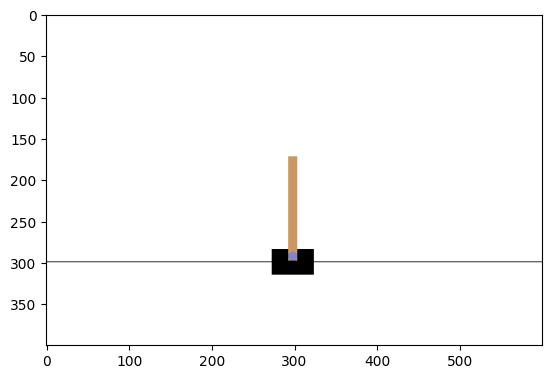

Total Reward: 2000.0


In [9]:
# make a new environment for the test
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
total_reward = 0

# play the environment
for step in range(2000):
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, truncated, info = env.step(action)
    total_reward += reward

    # visualize frame
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    if done:
        break

# print result
print(f"Total Reward: {total_reward}")

# it plays pretty well already!

In [ ]:
# The agent balanced the pole smoothly and steadily for all 2000 steps, showing perfect control.
# The upright pole and max reward of 2000.0 confirm stable and expert-level performance.